In [2]:
from pycocotools.coco import COCO
from sklearn.decomposition import PCA, TruncatedSVD
import numpy as np
import cv2
from tqdm import tqdm
import matplotlib.pyplot as plt
import skimage.io as io

!pip install pyod
from pyod.models.knn import KNN
from pyod.models.auto_encoder import AutoEncoder



In [3]:
dataDir='data'
dataType='val2017'
annFile='../{}/annotations/instances_{}.json'.format(dataDir,dataType)

# Initialize the COCO api for instance annotations
cocoData=COCO(annFile)

# Load the categories in a variable
catIDs = cocoData.getCatIds()
cats = cocoData.loadCats(catIDs)

loading annotations into memory...
Done (t=1.38s)
creating index...
index created!


In [4]:
# Define the classes (out of the 81) which you want to see. Others will not be shown.
filterClasses = ['pizza']

# Fetch class IDs only corresponding to the filterClasses
catIds = cocoData.getCatIds(catNms=filterClasses) 
# Get all images containing the above Category IDs
imgIds = cocoData.getImgIds(catIds=catIds)
print("Number of images containing all the  classes:", len(imgIds))

Number of images containing all the  classes: 153


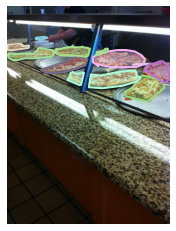

In [5]:
# load and display a random image
img = cocoData.loadImgs(imgIds[np.random.randint(0,len(imgIds))])[0]
I = io.imread('../{}/{}/{}'.format(dataDir,dataType,img['file_name']))/255.0

plt.imshow(I)
plt.axis('off')
annIds = cocoData.getAnnIds(imgIds=img['id'], catIds=catIds, iscrowd=0)
anns = cocoData.loadAnns(annIds)
cocoData.showAnns(anns)

In [6]:
def segmentTo2DArray(segmentation):
    polygon = []
    for partition in segmentation:
        for x, y in zip(partition[::2], partition[1::2]):
            polygon.append((x, y))
    return polygon


def maskPixels(polygon, img_dict, image_folder):
    img = cv2.imread("{}/{}".format(image_folder, img_dict["file_name"]))
    mask = np.zeros(img.shape, dtype=np.uint8)
    polygon = np.int32(polygon)
    mask = cv2.fillPoly(mask, pts=[polygon], color=(255, 255, 255))
    return img, mask


def getSegmentedMasks(filterClasses, image_folder, cocoData):
    # Returns single object annotation with black background
    catIds = cocoData.getCatIds(catNms=filterClasses)
    imgIds = cocoData.getImgIds(catIds=catIds)

    if len(imgIds) > 500:
        imgIds = random.sample(imgIds, 500)
    imgs = cocoData.loadImgs(imgIds)

    mask_annIds = []
    masks = []
    loaded_imgs = []
    for img_dict in tqdm(imgs):
        # Load annotations
        annIds = cocoData.getAnnIds(imgIds=img_dict["id"], catIds=catIds, iscrowd=0)
        anns = cocoData.loadAnns(annIds)
        mask_annIds.extend(annIds)
        # Create masked images
        for ann in anns:
            polyVerts = segmentTo2DArray(ann["segmentation"])
            img, mask = maskPixels(polyVerts, img_dict, image_folder)
            masks.append(mask)
            loaded_imgs.append(img)
    return loaded_imgs, masks, mask_annIds

image_folder = "../data/val2017"
imgs, masks, mask_annIds = getSegmentedMasks(['pizza'], image_folder, cocoData)

100%|████████████████████████████████████████████████████████████████████████████████| 153/153 [00:06<00:00, 25.50it/s]


In [7]:
def getObjPix(images, masks):
    img_masks = zip(images, masks)
    masked_imgs = []
    for image, mask in tqdm(img_masks):
        masked_image = cv2.bitwise_and(image, mask)
        masked_image = cv2.cvtColor(masked_image, cv2.COLOR_BGR2RGB)
        masked_image = masked_image.reshape((-1,) + masked_image.shape)
        masked_imgs.append(masked_image)
        print(masked_image.shape)
    return masked_imgs

X_train = getObjPix(imgs, masks)

82it [00:00, 349.89it/s]

(1, 427, 640, 3)
(1, 426, 640, 3)
(1, 426, 640, 3)
(1, 480, 640, 3)
(1, 480, 640, 3)
(1, 480, 640, 3)
(1, 480, 640, 3)
(1, 640, 480, 3)
(1, 640, 428, 3)
(1, 640, 480, 3)
(1, 640, 480, 3)
(1, 640, 640, 3)
(1, 640, 640, 3)
(1, 480, 640, 3)
(1, 480, 640, 3)
(1, 480, 640, 3)
(1, 361, 640, 3)
(1, 361, 640, 3)
(1, 375, 500, 3)
(1, 640, 480, 3)
(1, 640, 640, 3)
(1, 399, 500, 3)
(1, 480, 640, 3)
(1, 410, 640, 3)
(1, 612, 612, 3)
(1, 612, 612, 3)
(1, 427, 640, 3)
(1, 640, 427, 3)
(1, 640, 427, 3)
(1, 426, 640, 3)
(1, 426, 640, 3)
(1, 426, 640, 3)
(1, 426, 640, 3)
(1, 480, 640, 3)
(1, 480, 640, 3)
(1, 427, 640, 3)
(1, 359, 640, 3)
(1, 480, 640, 3)
(1, 480, 640, 3)
(1, 640, 480, 3)
(1, 427, 640, 3)
(1, 423, 640, 3)
(1, 480, 640, 3)
(1, 424, 640, 3)
(1, 424, 640, 3)
(1, 424, 640, 3)
(1, 424, 640, 3)
(1, 424, 640, 3)
(1, 424, 640, 3)
(1, 424, 640, 3)
(1, 424, 640, 3)
(1, 424, 640, 3)
(1, 424, 640, 3)
(1, 424, 640, 3)
(1, 424, 640, 3)
(1, 424, 640, 3)
(1, 427, 640, 3)
(1, 480, 640, 3)
(1, 640, 478, 

128it [00:00, 376.03it/s]

(1, 640, 480, 3)
(1, 428, 640, 3)
(1, 428, 640, 3)
(1, 428, 640, 3)
(1, 428, 640, 3)
(1, 428, 640, 3)
(1, 428, 640, 3)
(1, 428, 640, 3)
(1, 480, 640, 3)
(1, 426, 640, 3)
(1, 480, 640, 3)
(1, 480, 640, 3)
(1, 427, 640, 3)
(1, 480, 640, 3)
(1, 480, 640, 3)
(1, 480, 640, 3)
(1, 640, 480, 3)
(1, 480, 640, 3)
(1, 425, 640, 3)
(1, 640, 480, 3)
(1, 480, 640, 3)
(1, 480, 640, 3)
(1, 612, 612, 3)
(1, 612, 612, 3)
(1, 375, 500, 3)
(1, 640, 425, 3)
(1, 640, 480, 3)
(1, 427, 640, 3)
(1, 500, 375, 3)
(1, 480, 640, 3)
(1, 490, 640, 3)
(1, 612, 612, 3)
(1, 612, 612, 3)
(1, 375, 500, 3)
(1, 640, 480, 3)
(1, 640, 480, 3)
(1, 640, 480, 3)
(1, 640, 480, 3)
(1, 640, 480, 3)
(1, 480, 640, 3)
(1, 480, 640, 3)
(1, 640, 361, 3)
(1, 427, 640, 3)
(1, 300, 400, 3)
(1, 480, 640, 3)
(1, 480, 640, 3)
(1, 480, 640, 3)
(1, 640, 480, 3)
(1, 480, 640, 3)
(1, 424, 640, 3)
(1, 424, 640, 3)
(1, 520, 640, 3)
(1, 520, 640, 3)
(1, 480, 640, 3)
(1, 461, 640, 3)
(1, 461, 640, 3)
(1, 424, 640, 3)
(1, 424, 640, 3)
(1, 424, 640, 

235it [00:00, 442.40it/s]


(1, 640, 480, 3)
(1, 480, 640, 3)
(1, 640, 426, 3)
(1, 640, 426, 3)
(1, 640, 426, 3)
(1, 451, 640, 3)
(1, 478, 640, 3)
(1, 478, 640, 3)
(1, 481, 640, 3)
(1, 480, 640, 3)
(1, 480, 640, 3)
(1, 640, 478, 3)
(1, 640, 478, 3)
(1, 640, 478, 3)
(1, 480, 640, 3)
(1, 351, 640, 3)
(1, 640, 512, 3)
(1, 480, 640, 3)
(1, 478, 640, 3)
(1, 480, 640, 3)
(1, 480, 640, 3)
(1, 450, 640, 3)
(1, 500, 500, 3)
(1, 480, 640, 3)
(1, 480, 640, 3)
(1, 480, 640, 3)
(1, 480, 640, 3)
(1, 480, 640, 3)
(1, 480, 640, 3)
(1, 480, 640, 3)
(1, 480, 640, 3)
(1, 491, 640, 3)
(1, 427, 640, 3)
(1, 480, 640, 3)
(1, 480, 640, 3)
(1, 480, 640, 3)
(1, 480, 640, 3)
(1, 640, 426, 3)
(1, 640, 426, 3)
(1, 426, 640, 3)
(1, 426, 640, 3)
(1, 478, 640, 3)
(1, 478, 640, 3)
(1, 640, 409, 3)
(1, 427, 640, 3)
(1, 427, 640, 3)
(1, 478, 640, 3)
(1, 478, 640, 3)
(1, 478, 640, 3)
(1, 478, 640, 3)
(1, 478, 640, 3)
(1, 478, 640, 3)
(1, 361, 640, 3)
(1, 411, 640, 3)
(1, 480, 640, 3)
(1, 480, 640, 3)
(1, 640, 640, 3)
(1, 640, 640, 3)
(1, 640, 640,

284it [00:00, 478.12it/s]


(1, 640, 478, 3)
(1, 640, 478, 3)
(1, 640, 478, 3)
(1, 640, 478, 3)
(1, 640, 478, 3)


In [8]:
import numpy as np
import matplotlib.pyplot as plt
from tensorflow.keras.layers import Input, Dense, Conv2D, MaxPooling2D, UpSampling2D
from tensorflow.keras.models import Model
from tensorflow.keras import backend as K

import tensorflow as tf
from tensorflow.keras.applications.mobilenet_v2 import MobileNetV2,preprocess_input
from tensorflow.keras.layers import Input,GlobalMaxPooling2D,Dense
from tensorflow.keras.models import Model
from tensorflow.keras.preprocessing.image import img_to_array,load_img

In [9]:
input_img = Input(shape=(None, None, 3,))


x = Conv2D(32, (3, 3), activation='relu', padding='same')(input_img)
x = MaxPooling2D((2, 2), padding='same')(x)
x = Conv2D(32, (3, 3), activation='relu', padding='same')(x)
encoded = MaxPooling2D((2, 2), padding='same')(x)

x = Conv2D(32, (3, 3), activation='relu', padding='same')(encoded)
x = UpSampling2D((2, 2))(x)
x = Conv2D(32, (3, 3), activation='relu', padding='same')(x)
x = UpSampling2D((2, 2))(x)
decoded = Conv2D(3, (3, 3), activation='sigmoid', padding='same')(x)
autoencoder = Model(input_img, decoded)
autoencoder.compile(optimizer='adam', loss='binary_crossentropy')
autoencoder.summary()

Model: "functional_1"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_1 (InputLayer)         [(None, None, None, 3)]   0         
_________________________________________________________________
conv2d (Conv2D)              (None, None, None, 32)    896       
_________________________________________________________________
max_pooling2d (MaxPooling2D) (None, None, None, 32)    0         
_________________________________________________________________
conv2d_1 (Conv2D)            (None, None, None, 32)    9248      
_________________________________________________________________
max_pooling2d_1 (MaxPooling2 (None, None, None, 32)    0         
_________________________________________________________________
conv2d_2 (Conv2D)            (None, None, None, 32)    9248      
_________________________________________________________________
up_sampling2d (UpSampling2D) (None, None, None, 32)   

In [10]:
input_img = Input(shape=(None, None, 3))  

enocded_imag = Conv2D(32, (3, 3), activation='relu', padding='same')(input_img)
enocded_imag = MaxPooling2D((2, 2), padding='same')(enocded_imag)
enocded_imag = Conv2D(16, (3, 3), activation='relu', padding='same')(enocded_imag)
enocded_imag = MaxPooling2D((2, 2), padding='same')(enocded_imag)
enocded_imag = Conv2D(8, (3, 3), activation='relu', padding='same')(enocded_imag)
enocded_imag = MaxPooling2D((2, 2), padding='same')(enocded_imag)

decoded_imag = Conv2D(8, (2, 2), activation='relu', padding='same')(enocded_imag)
decoded_imag = UpSampling2D((2, 2))(decoded_imag)
decoded_imag = Conv2D(16, (3, 3), activation='relu', padding='same')(decoded_imag)
decoded_imag = UpSampling2D((2, 2))(decoded_imag)
decoded_imag = Conv2D(32, (3, 3), activation='relu', padding='same')(decoded_imag)
decoded_imag = UpSampling2D((2, 2))(decoded_imag)
# decoded_imag = Conv2D(3, (3, 3), activation='relu', padding='same')(decoded_imag)

# flat_layer = Flatten()(enocded_imag) 
# dense_layer = Dense(32,activation = "relu")(flat_layer) 
# output_layer = Dense(9, activation = "softmax")(dense_layer)

autoencoder = Model(input_img, decoded_imag)
autoencoder.compile(optimizer='adam', loss='binary_crossentropy')
autoencoder.summary()

Model: "functional_3"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_2 (InputLayer)         [(None, None, None, 3)]   0         
_________________________________________________________________
conv2d_5 (Conv2D)            (None, None, None, 32)    896       
_________________________________________________________________
max_pooling2d_2 (MaxPooling2 (None, None, None, 32)    0         
_________________________________________________________________
conv2d_6 (Conv2D)            (None, None, None, 16)    4624      
_________________________________________________________________
max_pooling2d_3 (MaxPooling2 (None, None, None, 16)    0         
_________________________________________________________________
conv2d_7 (Conv2D)            (None, None, None, 8)     1160      
_________________________________________________________________
max_pooling2d_4 (MaxPooling2 (None, None, None, 8)    

In [11]:
autoencoder.fit(
    X_train, X_train,
    epochs=100,
    batch_size=128,
    shuffle=True,
    verbose=2,
)

Epoch 1/100


ValueError: in user code:

    C:\Users\mrric\Anaconda3\lib\site-packages\tensorflow\python\keras\engine\training.py:806 train_function  *
        return step_function(self, iterator)
    C:\Users\mrric\Anaconda3\lib\site-packages\tensorflow\python\keras\engine\training.py:796 step_function  **
        outputs = model.distribute_strategy.run(run_step, args=(data,))
    C:\Users\mrric\Anaconda3\lib\site-packages\tensorflow\python\distribute\distribute_lib.py:1211 run
        return self._extended.call_for_each_replica(fn, args=args, kwargs=kwargs)
    C:\Users\mrric\Anaconda3\lib\site-packages\tensorflow\python\distribute\distribute_lib.py:2585 call_for_each_replica
        return self._call_for_each_replica(fn, args, kwargs)
    C:\Users\mrric\Anaconda3\lib\site-packages\tensorflow\python\distribute\distribute_lib.py:2945 _call_for_each_replica
        return fn(*args, **kwargs)
    C:\Users\mrric\Anaconda3\lib\site-packages\tensorflow\python\keras\engine\training.py:789 run_step  **
        outputs = model.train_step(data)
    C:\Users\mrric\Anaconda3\lib\site-packages\tensorflow\python\keras\engine\training.py:749 train_step
        y, y_pred, sample_weight, regularization_losses=self.losses)
    C:\Users\mrric\Anaconda3\lib\site-packages\tensorflow\python\keras\engine\compile_utils.py:204 __call__
        loss_value = loss_obj(y_t, y_p, sample_weight=sw)
    C:\Users\mrric\Anaconda3\lib\site-packages\tensorflow\python\keras\losses.py:149 __call__
        losses = ag_call(y_true, y_pred)
    C:\Users\mrric\Anaconda3\lib\site-packages\tensorflow\python\keras\losses.py:253 call  **
        return ag_fn(y_true, y_pred, **self._fn_kwargs)
    C:\Users\mrric\Anaconda3\lib\site-packages\tensorflow\python\util\dispatch.py:201 wrapper
        return target(*args, **kwargs)
    C:\Users\mrric\Anaconda3\lib\site-packages\tensorflow\python\keras\losses.py:1605 binary_crossentropy
        K.binary_crossentropy(y_true, y_pred, from_logits=from_logits), axis=-1)
    C:\Users\mrric\Anaconda3\lib\site-packages\tensorflow\python\util\dispatch.py:201 wrapper
        return target(*args, **kwargs)
    C:\Users\mrric\Anaconda3\lib\site-packages\tensorflow\python\keras\backend.py:4829 binary_crossentropy
        bce = target * math_ops.log(output + epsilon())
    C:\Users\mrric\Anaconda3\lib\site-packages\tensorflow\python\ops\math_ops.py:1141 binary_op_wrapper
        raise e
    C:\Users\mrric\Anaconda3\lib\site-packages\tensorflow\python\ops\math_ops.py:1125 binary_op_wrapper
        return func(x, y, name=name)
    C:\Users\mrric\Anaconda3\lib\site-packages\tensorflow\python\ops\math_ops.py:1457 _mul_dispatch
        return multiply(x, y, name=name)
    C:\Users\mrric\Anaconda3\lib\site-packages\tensorflow\python\util\dispatch.py:201 wrapper
        return target(*args, **kwargs)
    C:\Users\mrric\Anaconda3\lib\site-packages\tensorflow\python\ops\math_ops.py:509 multiply
        return gen_math_ops.mul(x, y, name)
    C:\Users\mrric\Anaconda3\lib\site-packages\tensorflow\python\ops\gen_math_ops.py:6176 mul
        "Mul", x=x, y=y, name=name)
    C:\Users\mrric\Anaconda3\lib\site-packages\tensorflow\python\framework\op_def_library.py:744 _apply_op_helper
        attrs=attr_protos, op_def=op_def)
    C:\Users\mrric\Anaconda3\lib\site-packages\tensorflow\python\framework\func_graph.py:593 _create_op_internal
        compute_device)
    C:\Users\mrric\Anaconda3\lib\site-packages\tensorflow\python\framework\ops.py:3485 _create_op_internal
        op_def=op_def)
    C:\Users\mrric\Anaconda3\lib\site-packages\tensorflow\python\framework\ops.py:1975 __init__
        control_input_ops, op_def)
    C:\Users\mrric\Anaconda3\lib\site-packages\tensorflow\python\framework\ops.py:1815 _create_c_op
        raise ValueError(str(e))

    ValueError: Dimensions must be equal, but are 427 and 432 for '{{node binary_crossentropy/mul}} = Mul[T=DT_FLOAT](binary_crossentropy/Cast, binary_crossentropy/Log)' with input shapes: [?,427,640,3], [?,432,640,32].
